In [1]:
#!pip install tensorflow==2.3.0rc2
#!pip install stn

In [1]:
import os
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, Add, AveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, MaxPooling2D, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report 
import seaborn as sns
from tensorflow.keras.utils import to_categorical
#-------------------------------
import tensorflow as tf
from numpy.random import seed
seed(1)
tf.random.set_seed(1)
#-------------------------------

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import metrics 
from sklearn.metrics import accuracy_score

In [3]:
class EmotionDetection():
    def preprocess_image(self, data_path):
        '''
        Parse information from a all files
        '''
        data_dir_list = os.listdir(data_path)
        img_data_list, numbers=[], []

        for dataset in data_dir_list:
            index = 0
            img_list=os.listdir(data_path+'/'+ dataset)
            print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
            for img in img_list:
                input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
                input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
                input_img_resize=cv2.resize(input_img,(48,48))
                input_img_resize = np.reshape(input_img_resize,(48,48,1))
                img_data_list.append(input_img_resize)
                index += 1
            numbers.append(index)
        img_data = np.array(img_data_list)
        img_data = img_data.astype('float32')
        img_data = img_data/255
        print(img_data.shape)
        return img_data
    
    def get_labels(self,img_data):
        '''
        Get labels of the image data
        '''
        num_of_samples = img_data.shape[0]
        labels = np.ones((num_of_samples,),dtype='int64')
        labels[0:134]=0 #135
        labels[135:188]=6 #54
        labels[189:365]=1 #177
        labels[366:440]=2 #75
        labels[441:647]=3 #207
        labels[648:731]=4 #84
        labels[732:980]=5 #249
        return labels
    
    def generate_split_data(self, img_data, labels, num_classes):
        '''
        Data distribution for train and test
        '''
        Y = tf.keras.utils.to_categorical(labels, num_classes)
        #Shuffle the dataset
        x,y = shuffle(img_data,Y, random_state=2)
        # Split the dataset
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=2)    
        return X_train, X_test, y_train, y_test
    
    def Convolution(self, input_tensor,filters):
        '''
        Define the Convolution layer
        '''
        x = Conv2D(filters=filters,kernel_size=(3, 3),padding = 'same',strides=(1, 1),kernel_regularizer=l2(0.001))(input_tensor)
        x = Dropout(0.1)(x)
        x= Activation('relu')(x)
        return x
    
    def model(self, input_shape):
        '''
        Model definition
        '''
        inputs = Input((input_shape))
        conv_1= self.Convolution(inputs,32)
        maxp_1 = MaxPooling2D(pool_size = (2,2)) (conv_1)
        conv_2 = self.Convolution(maxp_1,64)
        maxp_2 = MaxPooling2D(pool_size = (2, 2)) (conv_2)
        conv_3 = self.Convolution(maxp_2,128)
        maxp_3 = MaxPooling2D(pool_size = (2, 2)) (conv_3)
        conv_4 = self.Convolution(maxp_3,256)
        maxp_4 = MaxPooling2D(pool_size = (2, 2)) (conv_4)
        flatten= Flatten() (maxp_4)
        dense_1= Dense(128,activation='relu')(flatten)
        drop_1=Dropout(0.2)(dense_1)
        output= Dense(7,activation="softmax")(drop_1)
        model = Model(inputs=[inputs], outputs=[output])
        model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer="Adam",metrics=["accuracy"])
        return model
    
    def save_model(self, history, model, name_history, name_model):
        np.save(name_history+'.npy',history.history)
        model.save(name_model)

    def load_models(self, name_history, name_model):
        model = load_model(name_model)
        history=np.load(name_history+'.npy',allow_pickle='TRUE').item()
        return model, history

    def save_model_json_and_weights(self, model, test_acc, name_model):
        # Serialize and save model to JSON
        test_acc = int(test_acc * 10000)
        model_json = model.to_json()
        with open(name_model +'_'+ str(test_acc) + '.json', 'w') as json_file:
            json_file.write(model_json)
        # Serialize and save weights to JSON
        model.save_weights(name_model+'_' + str(test_acc) + '.h5')


    def load_model_and_weights(self, model_path, weights_path):
        # Loading JSON model
        json_file = open(model_path, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        model = model_from_json(loaded_model_json)
        # Loading weights
        model.load_weights(weights_path)
        print('Model and weights are loaded and compiled.')
        return loaded_model_json
    
    def loss_and_accurecy_model(self, history,name, save_nane ):
        '''
        A function that displays the accuracy and loss of a model
        '''
        plt.plot(history[name],'b',label='train_'+name)
        plt.plot(history['val_'+name],'r',label='val_'+name)
        plt.title('Model '+save_nane)
        plt.ylabel(save_nane)
        plt.xlabel('Epochs')
        plt.savefig(save_nane+'.png')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25, wspace=0.35)
        plt.show()
        plt.close()
        
    def get_data_predict(self, pred, y_test):
        '''
        A function that returns two lists: y_test and pred. 
        The lists contain the index of the maximum value for each image.
        '''
        y_test_list, pred_list = [], []
        for ind in range(len(pred)):
            y_test_list.append(int(np.argmax(y_test[ind])))
            pred_list.append(int(np.argmax(pred[ind])))    
        return y_test_list, pred_list
    
    def classification_report(self, y_test_list, pred_list, exp):
        # Function that returns a classification report
        return classification_report(y_test_list, pred_list, target_names = exp)
    
    def confusion_matrix(self, y_test_list, pred_list, exp, save_nane):
        # Function that returns a confusion matrix
        results = confusion_matrix(y_test_list, pred_list)
        plt.figure(figsize=(6,6))
        sns.heatmap(results, annot=True, xticklabels=exp, yticklabels=exp,  cbar=True)
        plt.xlabel('Predicted Label')
        plt.title(save_nane)
        plt.savefig(save_nane)
        plt.ylabel('True Label')
        plt.show()

### Data Preprcessing


In [5]:
data_path="file_input/CK+48"
data_generator = EmotionDetection()
img_data = data_generator.preprocess_image(data_path)

Loaded the images of dataset-anger

Loaded the images of dataset-contempt

Loaded the images of dataset-disgust

Loaded the images of dataset-fear

Loaded the images of dataset-happy

Loaded the images of dataset-sadness

Loaded the images of dataset-surprise

(981, 48, 48, 1)


In [66]:
num_classes = 7
exp = ['Angry','disgust','Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
labels = data_generator.get_labels(img_data)
X_train, X_test, y_train, y_test = data_generator.generate_split_data(img_data, labels, num_classes)
print(X_train.shape)
print(X_test.shape)

(882, 48, 48, 1)
(99, 48, 48, 1)


### Model

In [67]:
Model=data_generator.model(input_shape = (48,48,1))
Model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
dropout_20 (Dropout)         (None, 48, 48, 32)        0         
_________________________________________________________________
activation_16 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
dropout_21 (Dropout)         (None, 24, 24, 64)        0   

### Training

In [17]:
callback = tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)
History=Model.fit(X_train,y_train,batch_size=32,validation_data=(X_test,y_test),epochs=1000,callbacks=[callback])

Epoch 1/1000
28/28 [==============================] - 5s 139ms/step - loss: 2.0784 - accuracy: 0.2029 - val_loss: 1.9582 - val_accuracy: 0.3333
Epoch 2/1000
28/28 [==============================] - 4s 133ms/step - loss: 1.9451 - accuracy: 0.2528 - val_loss: 1.8591 - val_accuracy: 0.3333
Epoch 3/1000
28/28 [==============================] - 4s 136ms/step - loss: 1.8365 - accuracy: 0.2891 - val_loss: 1.7075 - val_accuracy: 0.4747
Epoch 4/1000
28/28 [==============================] - 4s 130ms/step - loss: 1.4845 - accuracy: 0.4751 - val_loss: 1.2800 - val_accuracy: 0.4646
Epoch 5/1000
28/28 [==============================] - 4s 134ms/step - loss: 1.1611 - accuracy: 0.6043 - val_loss: 0.9471 - val_accuracy: 0.6970
Epoch 6/1000
28/28 [==============================] - 4s 156ms/step - loss: 0.9393 - accuracy: 0.6757 - val_loss: 0.9410 - val_accuracy: 0.7273
Epoch 7/1000
28/28 [==============================] - 4s 153ms/step - loss: 0.8121 - accuracy: 0.7302 - val_loss: 0.7128 - val_accuracy:

### Save model and history

In [19]:
data_generator.save_model(History, Model, 'Emotion_detection/History_emotion_detection_CNN', 'Emotion_detection/Model_emotion_detection_CNN')

INFO:tensorflow:Assets written to: Model_emotion_detection_CNN\assets


In [68]:
Model, History=data_generator.load_models('Emotion_detection/History_emotion_detection_CNN', 'Emotion_detection/Model_emotion_detection_CNN')
Model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 32)        0         
_________________________________________________________________
activation (Activation)      (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0     

In [24]:
test_loss, test_acc = Model.evaluate(X_test, y_test, batch_size=32)
data_generator.save_model_json_and_weights(Model, test_acc,'Model_emotion_detection_CNN' )

4/4 [==============================] - 1s 16ms/step - loss: 0.1645 - accuracy: 1.0000


### Evaluation

In [25]:
score = Model.evaluate(X_train, y_train)

28/28 [==============================] - 1s 21ms/step - loss: 0.1641 - accuracy: 0.9932


In [69]:
pred=Model.predict(X_test)

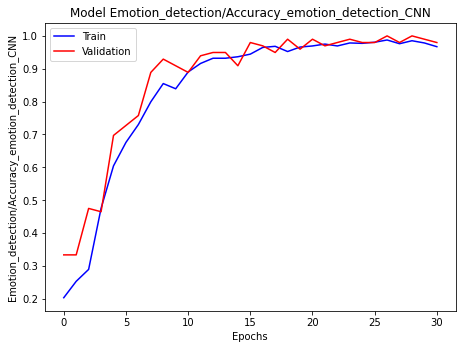

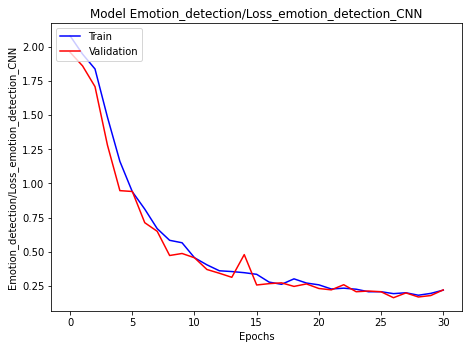

In [77]:
data_generator.loss_and_accurecy_model(History,'accuracy', 'Emotion_detection/Accuracy_emotion_detection_CNN' )
data_generator.loss_and_accurecy_model(History, 'loss','Emotion_detection/Loss_emotion_detection_CNN')

In [78]:
y_test_list, pred_list=data_generator.get_data_predict(pred, y_test)
report=data_generator.classification_report(y_test_list, pred_list, exp)
print(report)

              precision    recall  f1-score   support

       Angry       1.00      1.00      1.00        12
     disgust       1.00      1.00      1.00        19
        Fear       1.00      1.00      1.00         6
       Happy       1.00      1.00      1.00        17
         Sad       1.00      1.00      1.00         8
    Surprise       1.00      1.00      1.00        33
     Neutral       1.00      1.00      1.00         4

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99



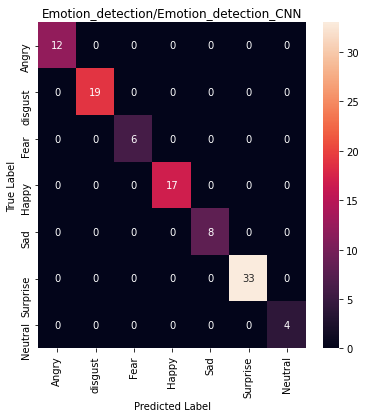

In [79]:
data_generator.confusion_matrix(y_test_list, pred_list, exp, 'Emotion_detection/Emotion_detection_CNN' )

### Reshape for Classifiers

In [80]:
m_samples = X_train.shape[0]
m_samplesTest = X_test.shape[0]
X_train1 = X_train.reshape(m_samples, -1)
X_test1 = X_test.reshape(m_samplesTest, -1)

In [81]:
print('X_test shape',X_test1.shape)
print('X_train1 shape',X_train1.shape)
print('y_train shape',y_train.shape)
print('y_test shape',y_test.shape)

X_test shape (99, 2304)
X_train1 shape (882, 2304)
y_train shape (882, 7)
y_test shape (99, 7)


In [82]:
y_train_list =[exp[np.argmax(y_train[i])] for i in range(y_train.shape[0])]
y_test_list =[exp[np.argmax(y_test[i])] for i in range(y_test.shape[0])]

### Decision Tree Classifier

In [83]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()
# Train Decision Tree Classifer
clf = clf.fit(X_train1,y_train)
# Model Accuracy, how often is the classifier correct?
y_pred = clf.predict(X_test1)

Accuracy Classifier: 88.89%
              precision    recall  f1-score   support

       Angry       0.79      0.92      0.85        12
     disgust       0.86      0.95      0.90        19
        Fear       1.00      0.50      0.67         6
       Happy       0.88      0.88      0.88        17
         Sad       1.00      0.75      0.86         8
    Surprise       0.91      0.94      0.93        33
     Neutral       1.00      1.00      1.00         4

    accuracy                           0.89        99
   macro avg       0.92      0.85      0.87        99
weighted avg       0.90      0.89      0.89        99



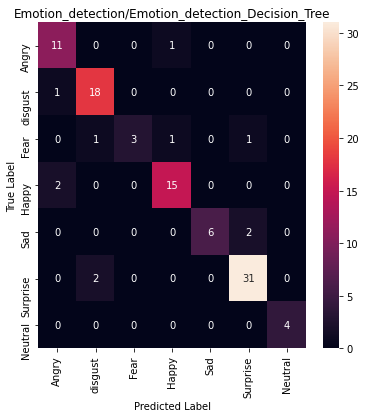

In [84]:
print("Accuracy Classifier: {}%".format(round(accuracy_score(y_test, y_pred)*100,2)))
print(data_generator.classification_report(y_test.argmax(axis=1),y_pred.argmax(axis=1), exp))
data_generator.confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1), exp, 'Emotion_detection/Emotion_detection_Decision_Tree')

### KNeighbors Classifier

In [85]:
classifier = KNeighborsClassifier(n_neighbors = 6, metric = 'minkowski', p = 2)
classifier = classifier.fit(X_train1, y_train)
# Model Accuracy, how often is the classifier correct?
y_pred = classifier.predict(X_test1)

Accuracy Classifier: 15.15%
              precision    recall  f1-score   support

       Angry       0.14      1.00      0.25        12
     disgust       0.67      0.11      0.18        19
        Fear       0.00      0.00      0.00         6
       Happy       1.00      0.06      0.11        17
         Sad       0.00      0.00      0.00         8
    Surprise       1.00      0.27      0.43        33
     Neutral       1.00      0.75      0.86         4

    accuracy                           0.27        99
   macro avg       0.54      0.31      0.26        99
weighted avg       0.69      0.27      0.26        99



C:\anconda_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anconda_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anconda_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


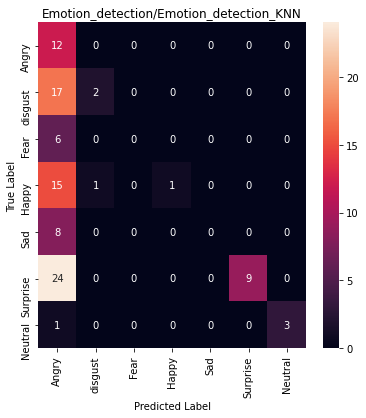

In [86]:
print("Accuracy Classifier: {}%".format(round(accuracy_score(y_test, y_pred)*100,2)))
print(data_generator.classification_report(y_test.argmax(axis=1),y_pred.argmax(axis=1), exp))
data_generator.confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1), exp, 'Emotion_detection/Emotion_detection_KNN')

### Random Forests

In [87]:
RF = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
RF.fit(X_train1, y_train)
# Model Accuracy, how often is the classifier correct?
y_pred = RF.predict(X_test1)


Accuracy Classifier: 23.23%
              precision    recall  f1-score   support

       Angry       0.16      1.00      0.27        12
     disgust       0.00      0.00      0.00        19
        Fear       0.00      0.00      0.00         6
       Happy       1.00      0.18      0.30        17
         Sad       0.00      0.00      0.00         8
    Surprise       1.00      0.61      0.75        33
     Neutral       0.00      0.00      0.00         4

    accuracy                           0.35        99
   macro avg       0.31      0.25      0.19        99
weighted avg       0.52      0.35      0.34        99



C:\anconda_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anconda_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anconda_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


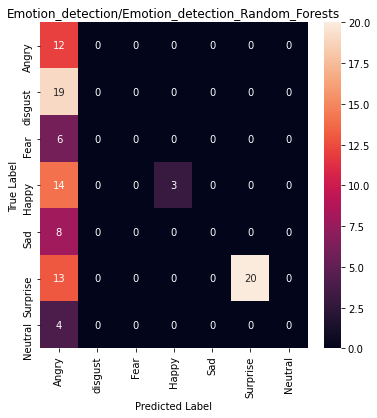

In [88]:
print("Accuracy Classifier: {}%".format(round(accuracy_score(y_test, y_pred)*100,2)))
print(data_generator.classification_report(y_test.argmax(axis=1),y_pred.argmax(axis=1), exp))
data_generator.confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1), exp, 'Emotion_detection/Emotion_detection_Random_Forests')

### Naive bayes

In [89]:
# instantiate the model
gnb = GaussianNB()
# fit the model
gnb.fit(X_train1, y_train_list)
y_pred = gnb.predict(X_test1)

Accuracy Classifier: 53.54%
              precision    recall  f1-score   support

       Angry       0.29      0.42      0.34        12
     disgust       0.00      0.00      0.00         6
        Fear       0.46      0.76      0.58        17
       Happy       0.25      0.75      0.38         4
         Sad       0.50      0.25      0.33         8
    Surprise       0.95      0.64      0.76        33
     Neutral       0.69      0.47      0.56        19

    accuracy                           0.54        99
   macro avg       0.45      0.47      0.42        99
weighted avg       0.62      0.54      0.55        99



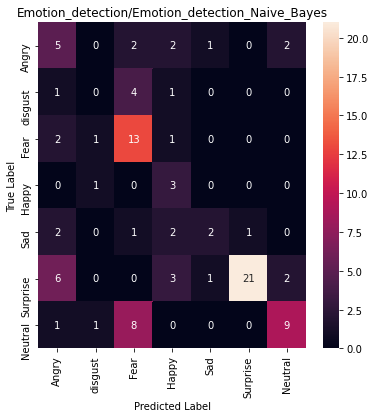

In [90]:
print("Accuracy Classifier: {}%".format(round(accuracy_score(y_test_list, y_pred)*100,2)))
print(data_generator.classification_report(y_test_list,y_pred, exp))
data_generator.confusion_matrix(y_test_list,y_pred, exp, 'Emotion_detection/Emotion_detection_Naive_Bayes')

## Support Vector Machines

In [91]:
SVM = svm.LinearSVC()
SVM.fit(X_train1, y_train_list)
y_pred = SVM.predict(X_test1)

C:\anconda_update\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Accuracy Classifier: 98.99%
              precision    recall  f1-score   support

       Angry       1.00      1.00      1.00        12
     disgust       1.00      0.83      0.91         6
        Fear       1.00      1.00      1.00        17
       Happy       1.00      1.00      1.00         4
         Sad       1.00      1.00      1.00         8
    Surprise       1.00      1.00      1.00        33
     Neutral       0.95      1.00      0.97        19

    accuracy                           0.99        99
   macro avg       0.99      0.98      0.98        99
weighted avg       0.99      0.99      0.99        99



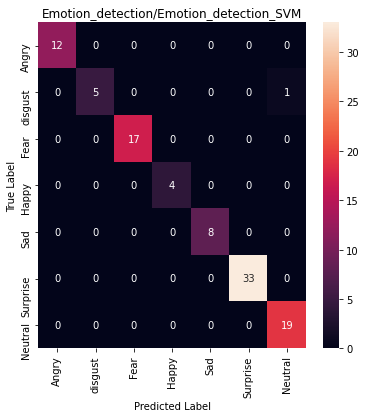

In [92]:
print("Accuracy Classifier: {}%".format(round(accuracy_score(y_test_list, y_pred)*100,2)))
print(data_generator.classification_report(y_test_list,y_pred, exp))
data_generator.confusion_matrix(y_test_list,y_pred, exp, 'Emotion_detection/Emotion_detection_SVM')

### Linear regression

In [93]:
reg = LinearRegression().fit(X_train1,y_train)
# Model Accuracy, how often is the classifier correct?
y_pred = reg.predict(X_test1)
y_pred_list =[exp[np.argmax(y_pred[i])] for i in range(y_pred.shape[0])] 

Accuracy Classifier: 98.99%
              precision    recall  f1-score   support

       Angry       1.00      1.00      1.00        12
     disgust       1.00      0.83      0.91         6
        Fear       1.00      1.00      1.00        17
       Happy       1.00      1.00      1.00         4
         Sad       1.00      1.00      1.00         8
    Surprise       1.00      1.00      1.00        33
     Neutral       0.95      1.00      0.97        19

    accuracy                           0.99        99
   macro avg       0.99      0.98      0.98        99
weighted avg       0.99      0.99      0.99        99



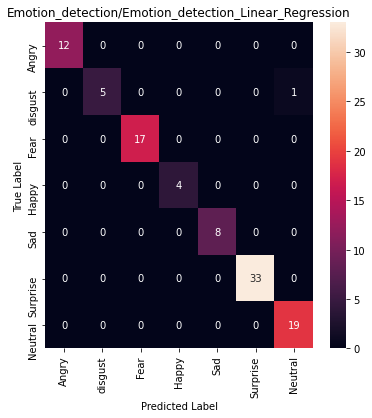

In [94]:
print("Accuracy Classifier: {}%".format(round(accuracy_score(y_test_list, y_pred_list)*100,2)))
print(data_generator.classification_report(y_test_list,y_pred_list, exp))
data_generator.confusion_matrix(y_test_list,y_pred_list, exp, 'Emotion_detection/Emotion_detection_Linear_Regression')